# pyklb User Guide

This notebook demonstrates how to use pyklb to read and write KLB (Keller Lab Block) files, a high-performance file format for 5D microscopy images.

## Installation

```bash
pip install pyklb
```

## Import libraries

In [1]:
import pyklb
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

print(f"pyklb version: {pyklb.__version__}")
print(f"Available functions: {pyklb.__all__}")

pyklb version: 0.3.0
Available functions: ['readheader', 'readfull', 'readroi', 'readfull_inplace', 'readroi_inplace', 'writefull']


## Load a KLB file

We'll use a sample file from the microscopy data.

In [5]:
# Path to the KLB file
klb_file = Path(r"D://klb//SPM00_TM000000_CM00_CHN01.klb")
# klb_file = Path(r"\\rbo-s1\S1_DATA\isoview\foconnell\io_corrected_test\klb\TM000000\SPM00_TM000000_CM00_CHN01.klb")

# Check if file exists
if klb_file.exists():
    print(f"✓ File found: {klb_file}")
    print(f"  File size: {klb_file.stat().st_size / (1024**2):.2f} MB")
else:
    print(f"✗ File not found: {klb_file}")
    print("\nPlease update the path to point to a valid KLB file.")

✓ File found: D:\klb\SPM00_TM000000_CM00_CHN01.klb
  File size: 72.21 MB


## 1. Reading KLB Headers

Before loading the entire file, you can read just the header to get metadata about the image.

In [6]:
# Read header information
header = pyklb.readheader(str(klb_file))

print("KLB File Header Information:")
print("=" * 50)
print(f"Image dimensions (TCZYX): {header['imagesize_tczyx']}")
print(f"Data type: {header['datatype']}")
print(f"Compression: {header['compression']}")
print(f"Pixel spacing (TCZYX): {header['pixelspacing_tczyx']}")
print(f"Block size (TCZYX): {header['blocksize_tczyx']}")

# Calculate total size
total_pixels = np.prod(header['imagesize_tczyx'])
print(f"\nTotal pixels: {total_pixels:,}")
print(f"Estimated uncompressed size: {total_pixels * np.dtype(header['datatype']).itemsize / (1024**2):.2f} MB")

KLB File Header Information:
Image dimensions (TCZYX): [   1    1   79 2048  752]
Data type: uint16
Compression: bzip2
Pixel spacing (TCZYX): [1. 1. 1. 1. 1.]
Block size (TCZYX): [ 1  1  8 96 96]

Total pixels: 121,667,584
Estimated uncompressed size: 232.06 MB


## 2. Reading the Full Image

Load the entire KLB file into a NumPy array.

**Note:** Dimension order is **TCZYX** (Time, Channel, Z, Y, X)

In [7]:
# Read the full image (uses all CPU cores by default)
img = pyklb.readfull(str(klb_file))

print(f"Image shape: {img.shape}")
print(f"Data type: {img.dtype}")
print(f"Memory usage: {img.nbytes / (1024**2):.2f} MB")
print(f"Value range: [{img.min()}, {img.max()}]")
print(f"Mean intensity: {img.mean():.2f}")

Image shape: (79, 2048, 752)
Data type: uint16
Memory usage: 232.06 MB
Value range: [34, 1145]
Mean intensity: 121.35


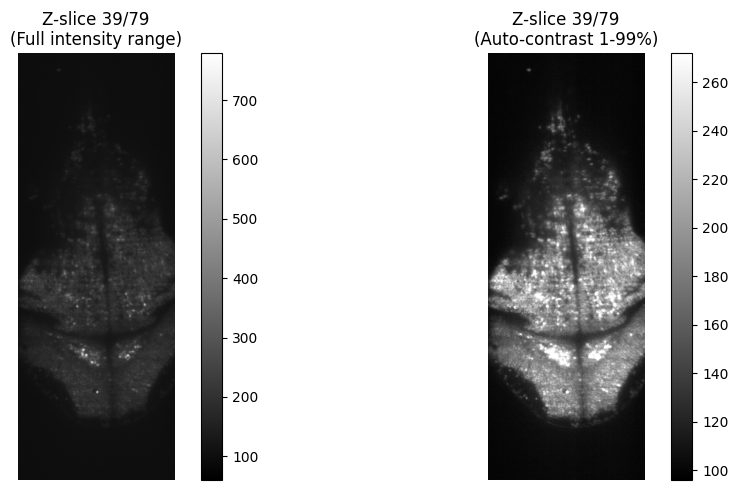

In [8]:
# Handle different dimensionalities
if img.ndim == 5:  # TCZYX
    t, c, z, y, x = img.shape
    # Get middle z-slice from first timepoint and channel
    slice_2d = img[0, 0, z//2, :, :]
    title = f"Z-slice {z//2}/{z} (T=0, C=0)"
elif img.ndim == 4:  # CZYX or TZYX
    d0, d1, d2, d3 = img.shape
    slice_2d = img[0, d1//2, :, :]
    title = f"Middle slice (dim0=0, dim1={d1//2}/{d1})"
elif img.ndim == 3:  # ZYX
    z, y, x = img.shape
    slice_2d = img[z//2, :, :]
    title = f"Z-slice {z//2}/{z}"
else:  # 2D
    slice_2d = img
    title = "2D Image"

# Plot the slice
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Full intensity range
im0 = axes[0].imshow(slice_2d, cmap='gray')
axes[0].set_title(f"{title}\n(Full intensity range)")
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Auto-contrast (clip to 1st and 99th percentiles)
vmin, vmax = np.percentile(slice_2d, [1, 99])
im1 = axes[1].imshow(slice_2d, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title(f"{title}\n(Auto-contrast 1-99%)")
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## 4. Reading a Region of Interest (ROI)

For large files, you can read just a specific region to save memory and time.

In [9]:
# Define ROI bounds (TCZYX order)
# Format: [min_t, min_c, min_z, min_y, min_x]
#         [max_t, max_c, max_z, max_y, max_x] (inclusive)

shape = header['imagesize_tczyx']

# Example: Read a small cube from the center
center = shape // 2
cube_size = 100

# Calculate bounds (make sure not to go out of bounds)
roi_min = np.maximum(center - cube_size // 2, 0)
roi_max = np.minimum(center + cube_size // 2, shape - 1)

print(f"Reading ROI: [{roi_min}] to [{roi_max}]")

# Read the ROI
roi = pyklb.readroi(str(klb_file), roi_min.tolist(), roi_max.tolist())

print(f"\nROI shape: {roi.shape}")
print(f"ROI memory: {roi.nbytes / (1024**2):.2f} MB")
print(f"ROI value range: [{roi.min()}, {roi.max()}]")
print(f"\nSpeedup: {img.nbytes / roi.nbytes:.1f}x less memory used")

Reading ROI: [[4294967246 4294967246 4294967285        974        326]] to [[   0    0   78 1074  426]]


IndexError: ROI index out of bounds: KLB size: [   1    1   79 2048  752], requested ROI: [4294967246 4294967246 4294967285        974        326]-[   0    0   78 1074  426]; file at D:\klb\SPM00_TM000000_CM00_CHN01.klb

## 5. Maximum Intensity Projection (MIP)

Create a maximum intensity projection along the Z-axis.

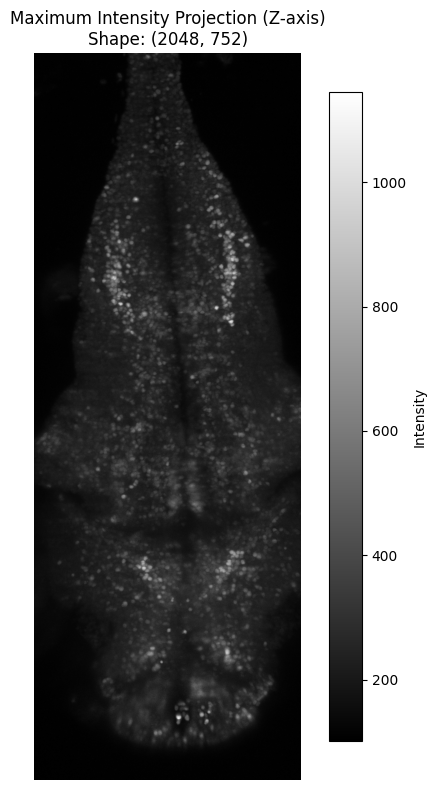

MIP shape: (2048, 752)
MIP value range: [101, 1145]


In [10]:
# Find the Z dimension
if img.ndim >= 3:
    # For 5D: TCZYX, take MIP over Z (axis 2)
    # For 4D: assume CZYX or TZYX, take MIP over appropriate axis
    # For 3D: assume ZYX, take MIP over axis 0
    
    if img.ndim == 5:
        mip = img[0, 0, :, :, :].max(axis=0)  # Max over Z
        axis_name = "Z"
    elif img.ndim == 4:
        mip = img[0, :, :, :].max(axis=0)  # Max over first spatial dim
        axis_name = "Z"
    else:  # 3D
        mip = img.max(axis=0)
        axis_name = "Z"
    
    plt.figure(figsize=(8, 8))
    plt.imshow(mip, cmap='gray')
    plt.title(f'Maximum Intensity Projection ({axis_name}-axis)\nShape: {mip.shape}')
    plt.colorbar(label='Intensity', fraction=0.046, pad=0.04)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"MIP shape: {mip.shape}")
    print(f"MIP value range: [{mip.min()}, {mip.max()}]")
else:
    print("Image is 2D, skipping MIP")

## 6. Writing KLB Files

You can write NumPy arrays back to KLB format with compression.

In [11]:
# Create a small test array
test_data = np.random.randint(0, 1000, size=(10, 100, 100), dtype=np.uint16)

# Output path
output_file = Path("test_output.klb")

print(f"Writing test data: shape={test_data.shape}, dtype={test_data.dtype}")

# Write with bzip2 compression (default) and pixel spacing
pyklb.writefull(
    test_data,
    str(output_file),
    pixelspacing_tczyx=[5.0, 0.5, 0.5],  # Z, Y, X spacing in microns
    compression="bzip2"  # Options: "none", "bzip2", "zlib"
)

print(f"✓ Wrote: {output_file}")
print(f"  File size: {output_file.stat().st_size / 1024:.2f} KB")

# Verify by reading back
read_back = pyklb.readfull(str(output_file))
header_back = pyklb.readheader(str(output_file))

print(f"\nVerification:")
print(f"  Data matches: {np.array_equal(test_data, read_back)}")
print(f"  Pixel spacing: {header_back['pixelspacing_tczyx']}")
print(f"  Compression: {header_back['compression']}")

# Clean up
output_file.unlink()
print(f"\n✓ Cleaned up test file")

Writing test data: shape=(10, 100, 100), dtype=uint16
✓ Wrote: test_output.klb
  File size: 127.25 KB

Verification:
  Data matches: True
  Pixel spacing: [1.  1.  5.  0.5 0.5]
  Compression: bzip2

✓ Cleaned up test file


## 7. Performance: In-place Reading

For better performance when reading repeatedly, you can pre-allocate arrays and read in-place.

In [18]:
import time

# Pre-allocate array
preallocated = np.empty(header['imagesize_tczyx'], dtype=header['datatype'])

print(f"Pre-allocated array: shape={preallocated.shape}, dtype={preallocated.dtype}")

# Time regular read
start = time.time()
img_normal = pyklb.readfull(str(klb_file))
time_normal = time.time() - start

# Time in-place read
start = time.time()
pyklb.readfull_inplace(preallocated, str(klb_file))
time_inplace = time.time() - start

print(f"\nTiming comparison:")
print(f"  Regular read: {time_normal:.3f} seconds")
print(f"  In-place read: {time_inplace:.3f} seconds")
print(f"  Speedup: {time_normal/time_inplace:.2f}x")
print(f"\nData matches: {np.array_equal(img_normal, preallocated.squeeze())}")

Pre-allocated array: shape=(1, 1, 79, 2048, 752), dtype=uint16

Timing comparison:
  Regular read: 0.341 seconds
  In-place read: 0.355 seconds
  Speedup: 0.96x

Data matches: True


In [17]:
img_normal.shape, preallocated.squeeze().shape

((79, 2048, 752), (79, 2048, 752))

## 8. Multi-threaded Decompression

KLB automatically uses all available CPU cores for decompression. You can control this with the `numthreads` parameter.

In [13]:
import multiprocessing

cpu_count = multiprocessing.cpu_count()
print(f"Available CPU cores: {cpu_count}")

# Test with different thread counts
thread_counts = [1, cpu_count // 2, cpu_count]

print("\nTiming with different thread counts:")
for n_threads in thread_counts:
    start = time.time()
    _ = pyklb.readfull(str(klb_file), numthreads=n_threads)
    elapsed = time.time() - start
    print(f"  {n_threads:2d} threads: {elapsed:.3f} seconds")

Available CPU cores: 32

Timing with different thread counts:
   1 threads: 6.471 seconds
  16 threads: 0.357 seconds
  32 threads: 0.339 seconds
